In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from os.path import join
import os
import random
from functools import partial
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate
from keras.optimizers import Nadam
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.backend import binary_crossentropy

import tensorflow as tf

K.clear_session()
K.set_image_dim_ordering('tf')

print(K.image_data_format())
smooth = 1e-12
num_examples = 0

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


channels_last


In [2]:
import glob
image_size = 512
def load_files():
    global image_size
    global num_examples
    mask_images=[]
    ori_images = []

    mask_path = "unet_train/gt/*"
    masks = glob.glob(mask_path)
    print("Loading masks")
    for fl in masks:
        train_image = cv2.imread(fl)
        shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
        start = shape[1]//3
        start = start * 2
        end = shape[1]
        train_image = train_image[: , start:end]
        train_image = cv2.resize(train_image, (image_size, image_size))
        lower_black = np.array([10,10,10], dtype = "uint16")
        upper_black = np.array([255,255,255], dtype = "uint16")
        black_mask = cv2.inRange(train_image, lower_black, upper_black)
        backtorgb = cv2.cvtColor(black_mask,cv2.COLOR_GRAY2BGR)
        mask_images.append(backtorgb)
    orig_path = "unet_train/orig/*"
    orig = glob.glob(orig_path)
    print("loading original")
    for fl in orig:
        orig_images = cv2.imread(fl)
        orig_images = cv2.resize(orig_images, (image_size, image_size))
        ori_images.append(orig_images)
    masked = np.array(mask_images)
    origi = np.array(ori_images)
    num_examples = masked.shape[0]
    return masked, origi

masks, origi = load_files()


Loading masks
loading original


In [3]:
def get_unet(size, n_cls):
    inputs = Input((size, size, 3))
    
    conv1 = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

In [4]:

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)



In [5]:
class BatchGenerator:
    
    def __init__(self, size, n_cls, batch_size):
        self.size = size
        self.n_cls = n_cls
        self.batch_size = batch_size
        self.i = 0
    
    def get_batch(self):
        global masks
        global origi
        while True:
            orig_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            gt_batch = np.zeros((self.batch_size, self.size, self.size, 3))
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            masks = [masks[j] for j in perm]
            origi = [origi[j] for j in perm]
            for i in range(self.batch_size):
                orig_batch[i] = origi[i]
                gt_batch[i] = masks[i]
            yield orig_batch, gt_batch

In [6]:
from keras.callbacks import TensorBoard
from time import time

train_batch_generator = BatchGenerator( image_size, 1, 1)
size = image_size
n_cls = 1
model = get_unet(size, n_cls)
model.compile(optimizer=Nadam(lr=1e-3), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
tensorboard = TensorBoard(log_dir="logs/", batch_size=4,write_graph=True)

model.fit_generator(train_batch_generator.get_batch(),steps_per_epoch=num_examples,epochs=20, callbacks=[tensorboard])

Epoch 1/20
62/62 [==============================] - 21s 344ms/step - loss: 4.0622 - binary_crossentropy: -164.7083 - jaccard_coef_int: 30.7604
Epoch 2/20
62/62 [==============================] - 18s 294ms/step - loss: 1.7107 - binary_crossentropy: -338.3221 - jaccard_coef_int: 82.1629
Epoch 3/20
62/62 [==============================] - 18s 294ms/step - loss: 1.1077 - binary_crossentropy: -441.8006 - jaccard_coef_int: 67.5840
Epoch 4/20
62/62 [==============================] - 18s 294ms/step - loss: 0.0068 - binary_crossentropy: -635.5567 - jaccard_coef_int: 92.5645
Epoch 5/20
62/62 [==============================] - 18s 294ms/step - loss: -1.1864 - binary_crossentropy: -810.9269 - jaccard_coef_int: 102.1004
Epoch 6/20
62/62 [==============================] - 18s 293ms/step - loss: -0.7697 - binary_crossentropy: -886.8249 - jaccard_coef_int: 95.2155
Epoch 7/20
62/62 [==============================] - 18s 294ms/step - loss: -2.0041 - binary_crossentropy: -1038.1077 - jaccard_coef_int: 11

In [ ]:
from importlib import reload
reload(K)
import h5py
model.save('modeltr.h5')

In [7]:
train_image = cv2.imread("1610.png")
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))


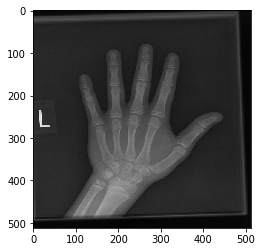

In [8]:
plt.imshow(train_image)
plt.show()

In [9]:
train_pic = np.array(train_image)
train_pic.shape

(512, 512, 3)

In [10]:
image = np.expand_dims(train_pic, axis=0)

In [11]:
image.shape

(1, 512, 512, 3)

In [12]:
mpo=model.predict(image)
#print(mpo)
mpo.shape

(1, 512, 512, 3)

In [13]:
mpo = mpo.reshape(512,512,3)

In [14]:
mpo.shape

(512, 512, 3)

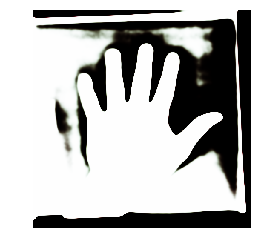

In [15]:
plt.axis('off')
plt.imshow(mpo)
#plt.savefig('output.png')
plt.show()

In [ ]:
hsv = cv2.cvtColor(mpo, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])
    # Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)
    # Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)
    cv2.imshow('frame',frame)
    cv2.imshow('mask',mask)
    cv2.imshow('res',res)

In [ ]:
train_image = cv2.imread('1901.jpg')
shape = train_image.shape
#Supervisely gives 3 images in out and we need the mask onl
start = shape[1]//3
end = 2 * start
train_image = train_image[: , start:end]
train_image = cv2.resize(train_image, (image_size, image_size))
print(len(train_image.shape))

In [ ]:
train_image.shape

In [ ]:
train_image = cv2.imread("1903.jpg")
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))
plt.axis('off')
plt.imshow(train_image)
plt.savefig('input.png')
plt.show()

In [ ]:

model = load_model('modeltr.h5', custom_objects={'jaccard_coef_int': jaccard_coef_int,'jaccard_coef_loss': jaccard_coef_loss})



In [ ]:
image_size =512
train_image = cv2.imread('testing/1384.png')
shape = train_image.shape
train_image = cv2.resize(train_image, (image_size, image_size))
train_pic = np.array(train_image)
image = np.expand_dims(train_pic, axis=0)

In [ ]:
image.shape


In [ ]:
g = model.predict(image)

In [ ]:
g.shape

In [ ]:
g = g.reshape(512,512,3)

In [ ]:
g.shape

In [ ]:
plt.imshow(g)

In [ ]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    return cv2.addWeighted(mask, 0.5, image, 0.5, 0.)

In [ ]:
import cv2
img= cv2.imread('train/boneage-training-dataset/1903.png')
img = cv2.resize(img, (512, 512))
image = np.expand_dims(img, axis=0)
g = model.predict(image)


In [ ]:
g.shape

In [ ]:
g.reshape(512,512,3)

In [ ]:
g.shape

In [ ]:
g.shape
largestCC = g == np.argmax(np.bincount(g.flat))

In [ ]:
plt.imshow(mask_overlay(img, (g > 0.5).astype(np.uint8)))

In [ ]:
plt.imshow(g)

In [ ]:
image = g.astype('uint')

In [ ]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.imshow("Biggest component", img2)
    cv2.waitKey()

In [ ]:
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat))
    return largestCC
a = getLargestCC(mpo)

In [ ]:
a=1-a
plt.imshow(a.astype(np.float32))

In [ ]:
g =g.reshape(512,512,3)

In [ ]:
g.dtype
a =np.finfo(np.float32).min

In [ ]:
g.dtype

In [ ]:

ball_ycrcb_mint = np.array([0, 90, 100],np.uint8)
ball_ycrcb_maxt = np.array([25, 255, 255],np.uint8)
ball_ycrcb = cv2.inRange(gray_image, ball_ycrcb_mint, ball_ycrcb_maxt)
#cv2.imwrite('Photos/output2.jpg', ball_ycrcb) # Second image
areaArray = []
count = 1

contours, _ = cv2.findContours(ball_ycrcb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    areaArray.append(area)

#first sort the array by area
sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

#find the nth largest contour [n-1][1], in this case 2
secondlargestcontour = sorteddata[1][1]

#draw it
x, y, w, h = cv2.boundingRect(secondlargestcontour)
cv2.drawContours(im, secondlargestcontour, -1, (255, 0, 0), 2)
cv2.rectangle(im, (x, y), (x+w, y+h), (0,255,0), 2)
cv2.imwrite('Photos/output3.jpg', im)

In [ ]:
plt.imshow(gray_image)

In [ ]:
ret, thresh = cv2.threshold(gray_image, 127, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 3)


In [ ]:
a = cv2.imread('1903.png')
arr = np.uint8(image)


In [ ]:
arr.shape

In [ ]:
train_image = cv2.resize(a, (image_size, image_size))
train_image = np.expand_dims(train_image, axis=0)
dk=model.predict(train_image)

In [ ]:
a= np.uint8(dk*255)
a= a.reshape(512,512,3)

In [ ]:
plt.imshow(a)
gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

In [ ]:
#cleaning the image
p = cv2.imread('train/boneage-training-dataset/1384.png')
train_image = cv2.resize(p, (image_size, image_size))
train_image = np.expand_dims(train_image, axis=0)
dk=model.predict(train_image)
a= np.uint8(dk*255)
a= a.reshape(512,512,3)
gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
mask = np.ones((512,512), dtype="uint8") * 255

_, contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    if area < 90000:
        cv2.drawContours(mask, [c], -1, 0, -1)

image = cv2.bitwise_and(a, a, mask=mask)    
plt.imshow(image)


In [ ]:
ball_ycrcb_mint = np.array([0, 90, 100],np.uint8)
ball_ycrcb_maxt = np.array([25, 255, 255],np.uint8)
ball_ycrcb = cv2.inRange(im_ycrcb, ball_ycrcb_mint, ball_ycrcb_maxt)
#cv2.imwrite('Photos/output2.jpg', ball_ycrcb) # Second image
areaArray = []
count = 1

contours, _ = cv2.findContours(ball_ycrcb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    areaArray.append(area)

#first sort the array by area
sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

#find the nth largest contour [n-1][1], in this case 2
secondlargestcontour = sorteddata[1][1]

#draw it
x, y, w, h = cv2.boundingRect(secondlargestcontour)
cv2.drawContours(im, secondlargestcontour, -1, (255, 0, 0), 2)
cv2.rectangle(im, (x, y), (x+w, y+h), (0,255,0), 2)

In [ ]:
new_img = np.zeros_like(arr)                                        # step 1
for val in np.unique(arr)[1:]:                                      # step 2
    mask = np.uint8(img == val)                                     # step 3
    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]  # step 4
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])      # step 5
    new_img[labels == largest_label] = val


In [ ]:
plt.imshow(image)
plt.show()
plt.imshow(p)
plt.show()

In [ ]:
d = model.predict(train_image)

In [ ]:
fig=plt.figure(figsize=(50, 50))
columns = 2
rows = 1
img = p
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.savefig('mamos.png')
fig.add_subplot(rows, columns, 2)
plt.imshow(a)
plt.title('image_test',fontsize=26)
plt.show()

In [ ]:
!ls    

In [ ]:
train_image = cv2.imread('1901.jpg')
shape = train_image.shape
        #Supervisely gives 3 images in out and we need the mask only
start = shape[1]//3
start = start * 2
end = shape[1]
train_image = train_image[: , start:end]
print(train_image.shape)

In [ ]:
gray=cv2.cvtColor(train_image,cv2.COLOR_BGR2GRAY)

(thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


In [ ]:
plt.imshow(im_bw)
plt.show()

In [ ]:
im_bw

In [ ]:
gray[500]